In [ ]:
!pip install lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 16.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=2229295cebe66751ed49b27be3c537710835733eba9f57eec49f9593fc599cf2
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50453 sha256=831473bba762bcae0184d44e056efca480fa6f29f5b6819757d4ebf9b99317c4
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b553d5e8b024

In [3]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.integrate import simps
from scipy.signal import savgol_filter
%matplotlib inline

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

<Figure size 2800x2000 with 0 Axes>

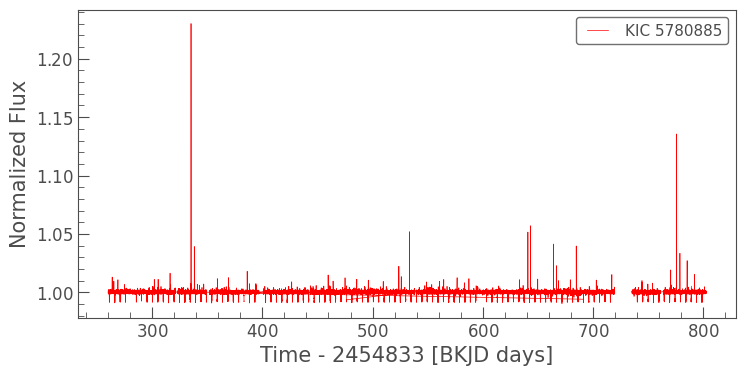

In [54]:
# Baixar e combinar a curva de luz
search_result = lk.search_lightcurve("Kepler-74b", author="Kepler", cadence="short")
lc_collection = search_result.download_all()
lc_stitched = lc_collection.stitch()

# Plotar a curva de luz
plt.figure(figsize=(28,20))
lc_stitched.plot(color='red')



In [77]:
# Definir parâmetros dos trânsitos
T0 = 134.3457036  # Tempo do meio do primeiro trânsito
Per = 7.340711 # Período orbital do planeta em dias
duracao_transito = 2 # Duração do trânsito em dias
tempo_min = lc_stitched.time.value.min()

# Ajuste do T0 caso seja menor que o tempo mínimo
if T0 < tempo_min:
    n =(tempo_min - T0) / Per
    N = int(n)  # Transformar n em um número inteiro
    T0 = (N + 1) * Per + T0
print(f"Tempo inicial: {tempo_min}")
print(f"Novo T0 ajustado: {T0}")

Tempo inicial: 260.2148673700067
Novo T0 ajustado: 266.4785016


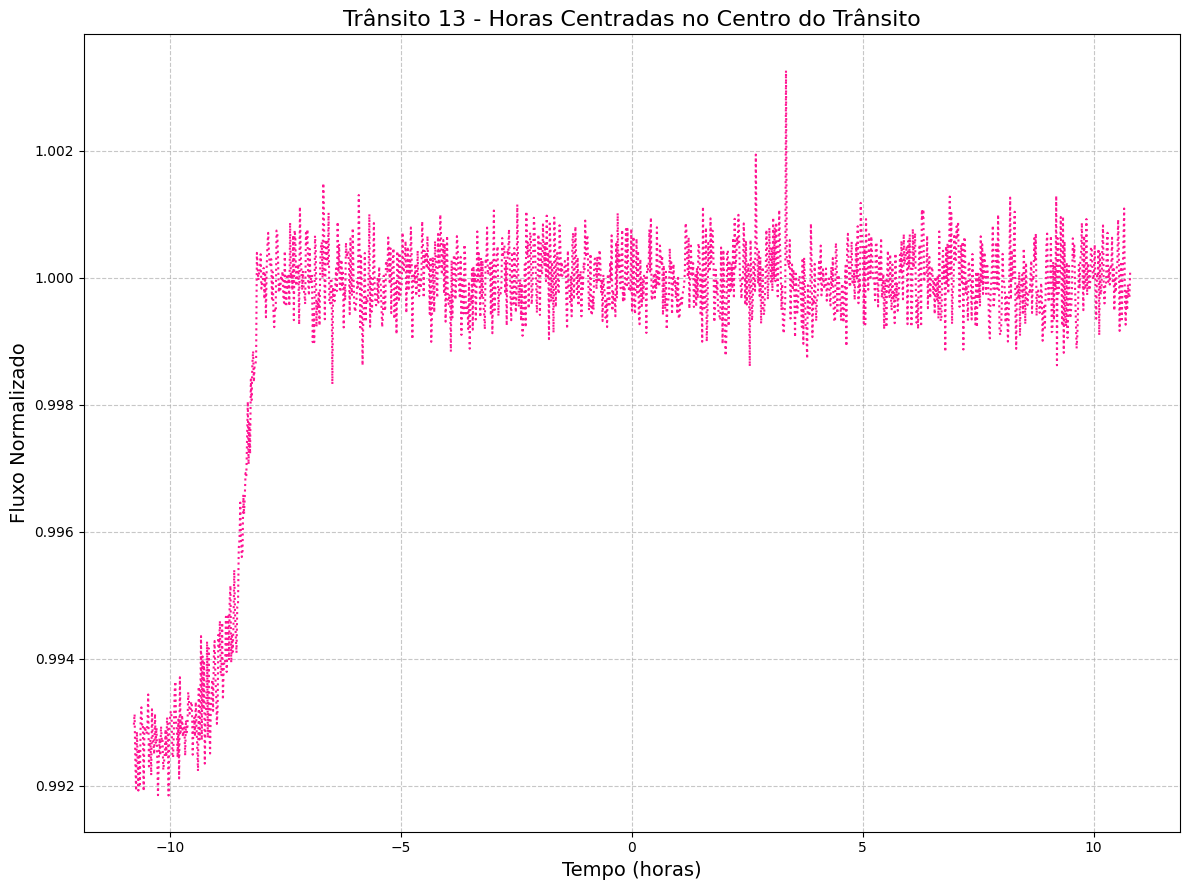

In [76]:
# Aumentar o tamanho do gráfico
plt.figure(figsize=(12, 9))

# Escolha do trânsito a ser plotado
transito_escolhido = 13


# Obter dados do trânsito escolhido
transit_time = lc_stitched.time
flux_norm = lc_stitched.flux #/ np.median(lc_stitched.flux)  # Normalizar o fluxo dividindo pela mediana

# Selecionar pontos correspondentes ao trânsito escolhido
mask = (transit_time.value >= T0 + (transito_escolhido - 1) * Per - duracao_transito / 2) & \
       (transit_time.value <= T0 + (transito_escolhido - 1) * Per + duracao_transito / 2)
transit_time_cut = transit_time[mask]
flux_norm_cut = flux_norm[mask]

# Converter tempo de dias para horas e centralizar em torno do centro do trânsito
transit_time_cut_hours = (transit_time_cut.value - T0 - (transito_escolhido - 1) * Per) * 24

# Plotar o trânsito escolhido com tempo em horas centrado no centro do trânsito
plt.plot(transit_time_cut_hours, flux_norm_cut.value, marker='', color='deeppink', linestyle='dotted')  # Usar .value para acessar os valores
plt.title(f"Trânsito {transito_escolhido} - Horas Centradas no Centro do Trânsito", fontsize=16)
plt.xlabel("Tempo (horas)", fontsize=14)
plt.ylabel("Fluxo Normalizado", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

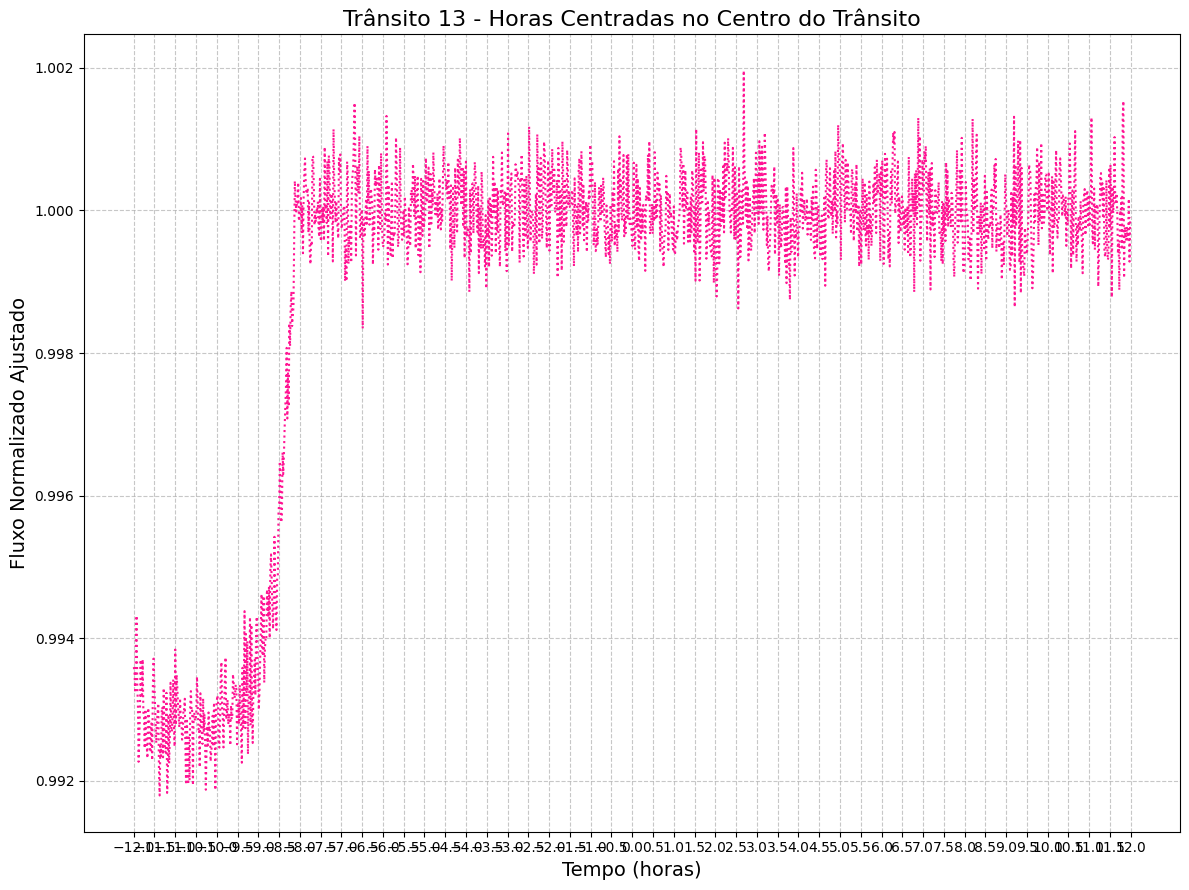

In [66]:
# Remover dados de baixa qualidade e NaNs
lc_cleaned = lc_stitched.remove_nans().remove_outliers(sigma=6)

# Filtrar os pontos de baixa qualidade (usando a máscara quality)
quality_mask = lc_cleaned.quality == 0
lc_cleaned = lc_cleaned[quality_mask]


plt.figure(figsize=(12, 9))

# Escolha do trânsito a ser plotado
transito_escolhido = 13

# Obter dados do trânsito escolhido
transit_time = lc_cleaned.time
flux_norm = lc_cleaned.flux / np.median(lc_cleaned.flux)  # Normalizar o fluxo dividindo pela mediana

# Selecionar pontos correspondentes ao trânsito escolhido
mask = (transit_time.value >= T0 + (transito_escolhido - 1) * Per - duracao_transito / 2) & \
       (transit_time.value <= T0 + (transito_escolhido - 1) * Per + duracao_transito / 2)
transit_time_cut = transit_time[mask]
flux_norm_cut = flux_norm[mask]

# Converter tempo de dias para horas e centralizar em torno do centro do trânsito
transit_time_cut_hours = (transit_time_cut.value - T0 - (transito_escolhido - 1) * Per) * 24

# Calcular a média dos fluxos no intervalo [-6, -3] horas para o trânsito escolhido
interval_start = -6  # Início do intervalo em horas
interval_end = -3    # Fim do intervalo em horas
interval_mask = (transit_time_cut_hours >= interval_start) & (transit_time_cut_hours <= interval_end)
flux_interval = flux_norm_cut[interval_mask]
media_flux = np.mean(flux_interval)

# Ajustar o fluxo normalizado pela média calculada
flux_norm_cut = flux_norm_cut / media_flux

# Plotar o trânsito escolhido com tempo em horas centrado no centro do trânsito
plt.plot(transit_time_cut_hours, flux_norm_cut.value, marker='', color='deeppink', linestyle='dotted', label='Dados originais')
plt.title(f"Trânsito {transito_escolhido} - Horas Centradas no Centro do Trânsito", fontsize=16)
plt.xlabel("Tempo (horas)", fontsize=14)
plt.ylabel("Fluxo Normalizado Ajustado", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Definir mais pontos de referência no eixo x
x_ticks = np.arange(-duracao_transito * 24 / 2, duracao_transito * 24 / 2 + 0.5, 0.5)
plt.xticks(x_ticks)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

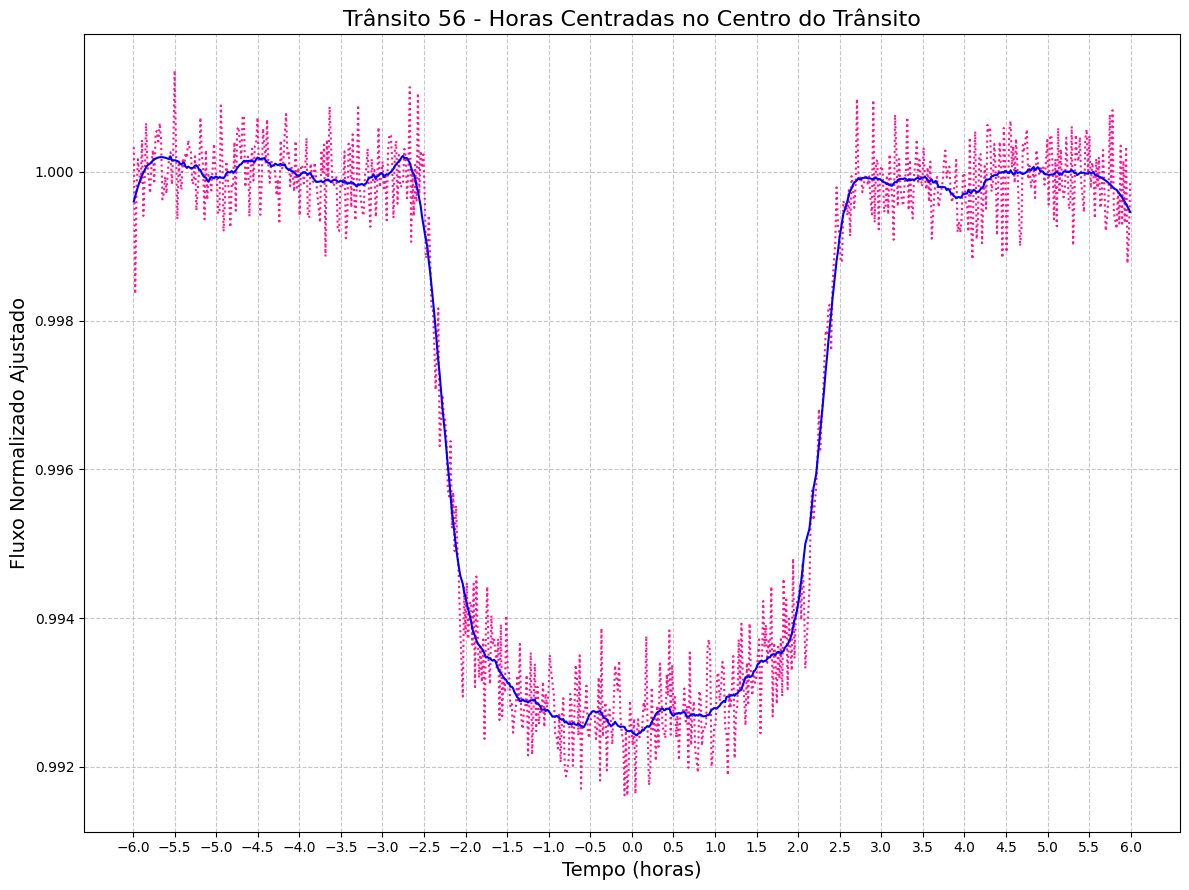

Média dos fluxos no intervalo [-6, -3] horas para o trânsito 56: 1.00006


In [58]:
 # Remover dados de baixa qualidade e NaNs
lc_cleaned = lc_stitched.remove_nans().remove_outliers(sigma=6)

# Filtrar os pontos de baixa qualidade (usando a máscara quality)
quality_mask = lc_cleaned.quality == 0
lc_cleaned = lc_cleaned[quality_mask]

plt.figure(figsize=(12, 9))

# Escolha do trânsito a ser plotado
transito_escolhido = 56


# Obter dados do trânsito escolhido
transit_time = lc_cleaned.time
flux_norm = lc_cleaned.flux / np.median(lc_cleaned.flux)  # Normalizar o fluxo dividindo pela mediana

# Selecionar pontos correspondentes ao trânsito escolhido
mask = (transit_time.value >= T0 + (transito_escolhido - 1) * Per - duracao_transito / 2) & \
       (transit_time.value <= T0 + (transito_escolhido - 1) * Per + duracao_transito / 2)
transit_time_cut = transit_time[mask]
flux_norm_cut = flux_norm[mask]

# Converter tempo de dias para horas e centralizar em torno do centro do trânsito
transit_time_cut_hours = (transit_time_cut.value - T0 - (transito_escolhido - 1) * Per) * 24

# Calcular a média dos fluxos no intervalo [-6, -3] horas para o trânsito escolhido
interval_start = -6  # Início do intervalo em horas
interval_end = -3    # Fim do intervalo em horas
interval_mask = (transit_time_cut_hours >= interval_start) & (transit_time_cut_hours <= interval_end)
flux_interval = flux_norm_cut[interval_mask]
media_flux = np.mean(flux_interval)

# Ajustar o fluxo normalizado pela média calculada
flux_norm_cut = flux_norm_cut / media_flux

# Aplicar o filtro Savitzky-Golay para suavizar os dados
flux_smooth = savgol_filter(flux_norm_cut, window_length=51, polyorder=3)

# Plotar o trânsito escolhido com tempo em horas centrado no centro do trânsito
plt.plot(transit_time_cut_hours, flux_norm_cut.value, marker='', color='deeppink', linestyle='dotted', label='Dados originais')
plt.plot(transit_time_cut_hours, flux_smooth, marker='', color='blue', linestyle='-', label='Dados suavizados')
plt.title(f"Trânsito {transito_escolhido} - Horas Centradas no Centro do Trânsito", fontsize=16)
plt.xlabel("Tempo (horas)", fontsize=14)
plt.ylabel("Fluxo Normalizado Ajustado", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Definir mais pontos de referência no eixo x
x_ticks = np.arange(-duracao_transito * 24 / 2, duracao_transito * 24 / 2 + 0.5, 0.5)
plt.xticks(x_ticks)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

# Exibir a média calculada
print(f"Média dos fluxos no intervalo [{interval_start}, {interval_end}] horas para o trânsito {transito_escolhido}: {media_flux:.5f}")

In [59]:

# Obter dados de tempo e fluxo
transit_time = lc_cleaned.time
flux_norm = lc_cleaned.flux / np.median(lc_cleaned.flux)  # Normalizar o fluxo dividindo pela mediana

# Aplicar o filtro Savitzky-Golay para suavizar os dados
flux_smooth = savgol_filter(flux_norm, window_length=51, polyorder=3)

# Solicitar intervalo do usuário
interval_start_user = float(input("Digite o início do intervalo em horas: "))
interval_end_user = float(input("Digite o fim do intervalo em horas: "))

# Inicializar lista para armazenar trânsitos com fluxo abaixo da média
transitos_com_fluxo_baixo = []

# Iterar sobre os trânsitos
for transito_escolhido in range(1, 101):  # Ajustar o número máximo de trânsitos conforme necessário
    # Selecionar pontos correspondentes ao trânsito escolhido
    mask = (transit_time.value >= T0 + (transito_escolhido - 1) * Per - duracao_transito / 2) & \
           (transit_time.value <= T0 + (transito_escolhido - 1) * Per + duracao_transito / 2)
    transit_time_cut = transit_time[mask]
    flux_smooth_cut = flux_smooth[mask]

    # Converter tempo de dias para horas e centralizar em torno do centro do trânsito
    transit_time_cut_hours = (transit_time_cut.value - T0 - (transito_escolhido - 1) * Per) * 24

    # Calcular a média dos fluxos suavizados no intervalo [-6, -3] horas e seu desvio padrão
    interval_start = -6
    interval_end = -3
    interval_mask = (transit_time_cut_hours >= interval_start) & (transit_time_cut_hours <= interval_end)
    flux_interval = flux_smooth_cut[interval_mask]
    media_flux = np.mean(flux_interval)
    desvio_padrao_flux = np.std(flux_interval)

    # Calcular a média dos fluxos suavizados no intervalo fornecido pelo usuário
    interval_mask_user = (transit_time_cut_hours >= interval_start_user) & (transit_time_cut_hours <= interval_end_user)
    flux_interval_user = flux_smooth_cut[interval_mask_user]
    media_flux_user = np.mean(flux_interval_user)

    # Verificar se a média do intervalo do usuário é menor que a média do intervalo [-6, -3] horas menos o desvio padrão
    if media_flux_user < (media_flux - desvio_padrao_flux):
        transitos_com_fluxo_baixo.append(transito_escolhido)

# Exibir os trânsitos que atendem à condição
print(f"Trânsitos com média de fluxo no intervalo do usuário menor que a média do intervalo [-6, -3] horas menos o desvio padrão: {transitos_com_fluxo_baixo}")

Digite o início do intervalo em horas: 1.030
Digite o fim do intervalo em horas: 1.649
Trânsitos com média de fluxo no intervalo do usuário menor que a média do intervalo [-6, -3] horas menos o desvio padrão: [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 99, 100]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
